In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/NetworkData.csv'  # Replace with your file's path
network_data = pd.read_csv(file_path)

# Inspect the dataset
print(network_data.info())
print(network_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191033 entries, 0 to 191032
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             191033 non-null  int64  
 1    Flow Duration                191033 non-null  int64  
 2    Total Fwd Packets            191033 non-null  int64  
 3    Total Backward Packets       191033 non-null  int64  
 4   Total Length of Fwd Packets   191033 non-null  int64  
 5    Total Length of Bwd Packets  191033 non-null  int64  
 6    Fwd Packet Length Max        191033 non-null  int64  
 7    Fwd Packet Length Min        191033 non-null  int64  
 8    Fwd Packet Length Mean       191033 non-null  float64
 9    Fwd Packet Length Std        191033 non-null  float64
 10  Bwd Packet Length Max         191033 non-null  int64  
 11   Bwd Packet Length Min        191033 non-null  int64  
 12   Bwd Packet Length Mean       191033 non-nul

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Clean column names
network_data.columns = network_data.columns.str.strip()

# Step 2: Drop rows with missing values
network_data_cleaned = network_data.dropna()

# Step 3: Isolate the Label column for later evaluation
labels = network_data_cleaned['Label']
features = network_data_cleaned.drop(columns=['Label'])

# Step 4: Select only numerical features
numerical_features = features.select_dtypes(include=['float64', 'int64'])

# Step 5: Handle infinite values
numerical_features = numerical_features.replace([np.inf, -np.inf], np.nan).dropna()

# Step 6: Standardize the features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Convert back to a DataFrame for easier handling
numerical_features_scaled_df = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)
# Save the preprocessed data
features_output_path = 'preprocessed_features.csv'
labels_output_path = 'labels.csv'
numerical_features_scaled_df.to_csv(features_output_path, index=False)
labels.to_csv(labels_output_path, index=False)

print(f"Preprocessed features saved to {features_output_path}")
print(f"Labels saved to {labels_output_path} for evaluation")


Preprocessed features saved to preprocessed_features.csv
Labels saved to labels.csv for evaluation


In [ ]:

import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score

# Load preprocessed data
features_path = 'preprocessed_features.csv'
labels_path = 'labels.csv'

features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path).squeeze()  # Ensure labels is a Series

# Ensure labels align with features after preprocessing
labels = labels.iloc[:len(features)]  # Truncate or reindex labels to match features

# Convert string labels to integers
label_mapping = {'BENIGN': 0, 'Bot': 1}  # Adjust based on actual label names in your data
labels = labels.map(label_mapping)

# Step 1: Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(features)

# Step 2: Predict anomalies
predictions = isolation_forest.predict(features)
# Convert predictions to binary: -1 (anomaly) -> 1, 1 (normal) -> 0
binary_predictions = (predictions == -1).astype(int)

# Step 3: Evaluate using the Label column
print("Classification Report:")
print(classification_report(labels, binary_predictions, target_names=['Normal', 'Bot']))

# Optional: ROC AUC Score
auc = roc_auc_score(labels, binary_predictions)
print(f"ROC AUC Score: {auc:.4f}")

# Step 4: Save the results in a CSV file
results_df = pd.DataFrame({
    'Actual_Label': labels,
    'Predicted_Label': binary_predictions
})

# Save to CSV file
results_df.to_csv('isolation_forest_results.csv', index=False)

print("Results saved to 'isolation_forest_results.csv'")

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97    188952
         Bot       0.01      0.04      0.01      1959

    accuracy                           0.94    190911
   macro avg       0.50      0.50      0.49    190911
weighted avg       0.98      0.94      0.96    190911

ROC AUC Score: 0.4965
Results saved to 'isolation_forest_results.csv'


In [ ]:
# Count the occurrences of 'Normal' and 'Bot' in the labels
normal_count = (labels == 0).sum()  # 'Normal' is 0
bot_count = (labels == 1).sum()     # 'Bot' is 1

print(f"Normal Count: {normal_count}")
print(f"Bot Count: {bot_count}")


Normal Count: 188952
Bot Count: 1959


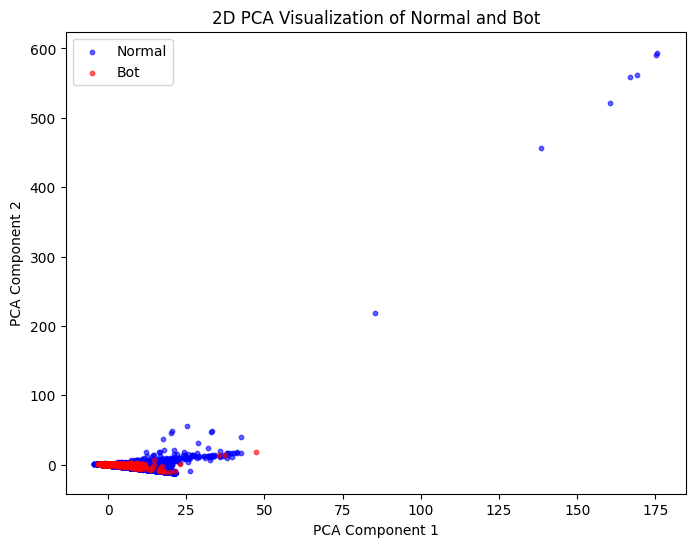

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Create a scatter plot of the 2D projection
plt.figure(figsize=(8, 6))

# Plot 'Normal' class (label 0) and 'Bot' class (label 1)
plt.scatter(reduced_features[labels == 0, 0], reduced_features[labels == 0, 1],
            c='blue', label='Normal', alpha=0.6, s=10)
plt.scatter(reduced_features[labels == 1, 0], reduced_features[labels == 1, 1],
            c='red', label='Bot', alpha=0.6, s=10)

# Add labels and title
plt.title('2D PCA Visualization of Normal and Bot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Display legend
plt.legend()

# Show plot
plt.show()


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    188952
         Bot       0.01      0.01      0.01      1959

    accuracy                           0.98    190911
   macro avg       0.50      0.50      0.50    190911
weighted avg       0.98      0.98      0.98    190911

ROC AUC Score: 0.5014


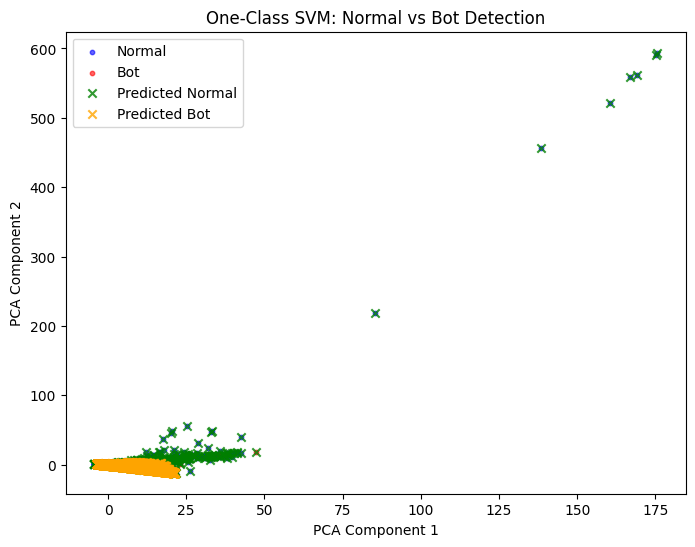

Results saved to 'one_class_svm_results.csv'


In [ ]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load preprocessed data
features_path = 'preprocessed_features.csv'
labels_path = 'labels.csv'

features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path).squeeze()  # Ensure labels is a Series

# Ensure labels align with features after preprocessing
labels = labels.iloc[:len(features)]  # Truncate or reindex labels to match features

# Convert string labels to integers
label_mapping = {'BENIGN': 0, 'Bot': 1}  # Adjust based on actual label names in your data
labels = labels.map(label_mapping)

# Step 1: Train One-Class SVM (using Normal class only for training)
normal_features = features[labels == 0]  # Only use 'Normal' data to train the One-Class SVM

# Initialize One-Class SVM model (without the random_state)
one_class_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma='scale')
one_class_svm.fit(normal_features)

# Step 2: Predict anomalies (Outliers = -1, Inliers = 1)
predictions = one_class_svm.predict(features)
binary_predictions = (predictions == -1).astype(int)  # Convert to binary: -1 = anomaly (Bot), 1 = inlier (Normal)

# Step 3: Evaluate the model using classification report
print("Classification Report:")
print(classification_report(labels, binary_predictions, target_names=['Normal', 'Bot']))

# Optional: ROC AUC Score
auc = roc_auc_score(labels, binary_predictions)
print(f"ROC AUC Score: {auc:.4f}")

# Optional: Plotting the results (2D PCA Visualization for example)
# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[labels == 0, 0], reduced_features[labels == 0, 1],
            c='blue', label='Normal', alpha=0.6, s=10)
plt.scatter(reduced_features[labels == 1, 0], reduced_features[labels == 1, 1],
            c='red', label='Bot', alpha=0.6, s=10)
plt.scatter(reduced_features[binary_predictions == 1, 0], reduced_features[binary_predictions == 1, 1],
            c='green', label='Predicted Normal', marker='x', alpha=0.8)
plt.scatter(reduced_features[binary_predictions == 0, 0], reduced_features[binary_predictions == 0, 1],
            c='orange', label='Predicted Bot', marker='x', alpha=0.8)

# Add labels and title
plt.title('One-Class SVM: Normal vs Bot Detection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Display legend
plt.legend()

# Show plot
plt.show()

# Step 4: Save the results in a CSV file
results_df = pd.DataFrame({
    'Actual_Label': labels,
    'Predicted_Label': binary_predictions
})

# Save to CSV file
results_df.to_csv('one_class_svm_results.csv', index=False)

print("Results saved to 'one_class_svm_results.csv'")


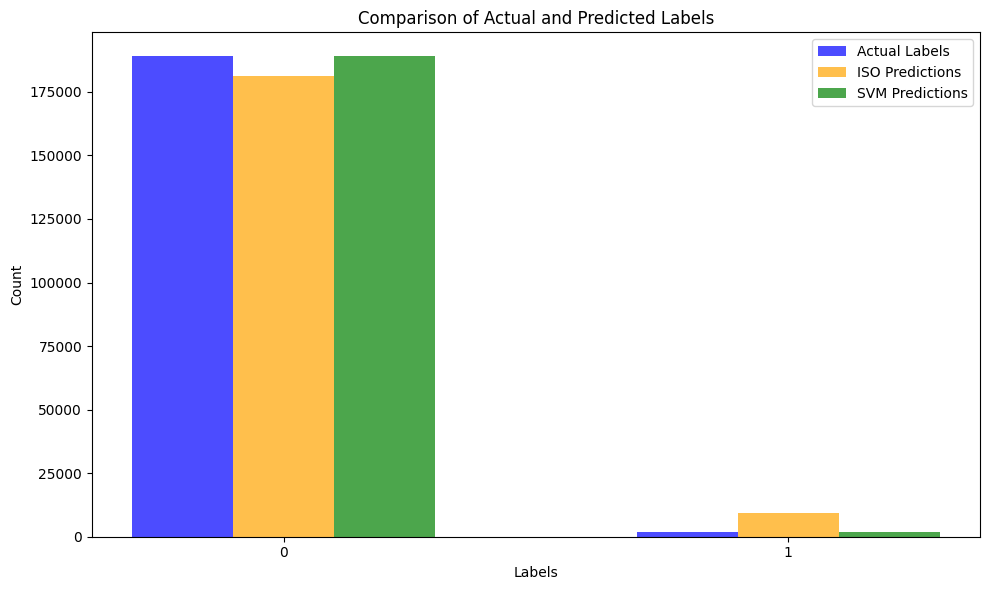

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/content/comparison_results.csv'
data = pd.read_csv(file_path)

# Count occurrences of each label in each column
actual_counts = data['Actual_Label'].value_counts().sort_index()
iso_counts = data['ISO_Predicted_Label'].value_counts().sort_index()
svm_counts = data['SVM_Predicted_Label'].value_counts().sort_index()

# Align counts for consistent comparison
labels = sorted(set(data['Actual_Label']).union(data['ISO_Predicted_Label']).union(data['SVM_Predicted_Label']))
actual_counts = actual_counts.reindex(labels, fill_value=0)
iso_counts = iso_counts.reindex(labels, fill_value=0)
svm_counts = svm_counts.reindex(labels, fill_value=0)

# Create bar chart
x = range(len(labels))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], actual_counts, width=width, label='Actual Labels', color='blue', alpha=0.7)
plt.bar(x, iso_counts, width=width, label='ISO Predictions', color='orange', alpha=0.7)
plt.bar([i + width for i in x], svm_counts, width=width, label='SVM Predictions', color='green', alpha=0.7)

# Add labels and legend
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Labels')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


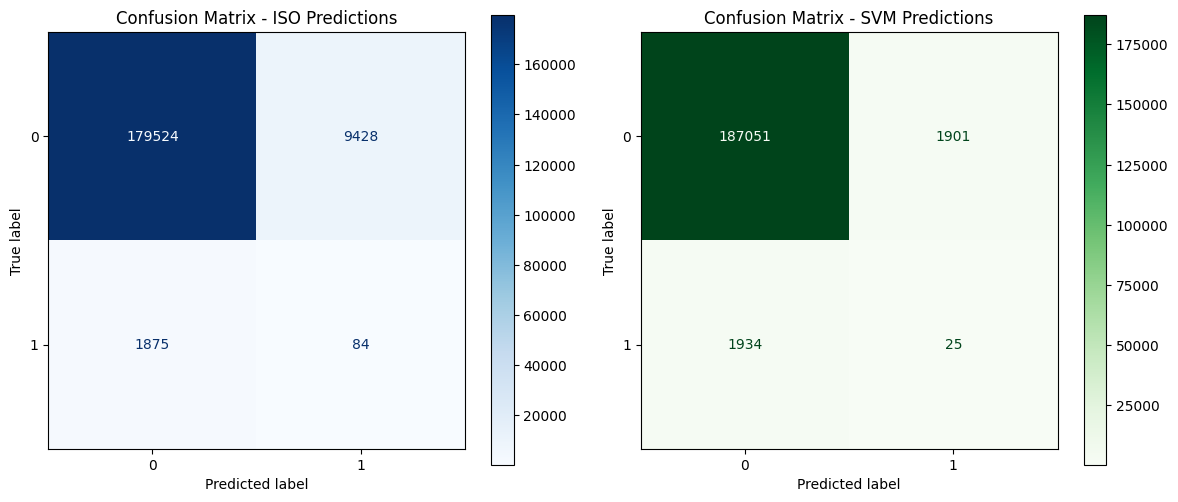

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
confusion_matrix_iso = confusion_matrix(data['Actual_Label'], data['ISO_Predicted_Label'])
confusion_matrix_svm = confusion_matrix(data['Actual_Label'], data['SVM_Predicted_Label'])

# Plot confusion matrix for ISO predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay(confusion_matrix_iso, display_labels=labels).plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - ISO Predictions')

# Plot confusion matrix for SVM predictions
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay(confusion_matrix_svm, display_labels=labels).plot(cmap='Greens', ax=plt.gca())
plt.title('Confusion Matrix - SVM Predictions')

plt.tight_layout()
plt.show()


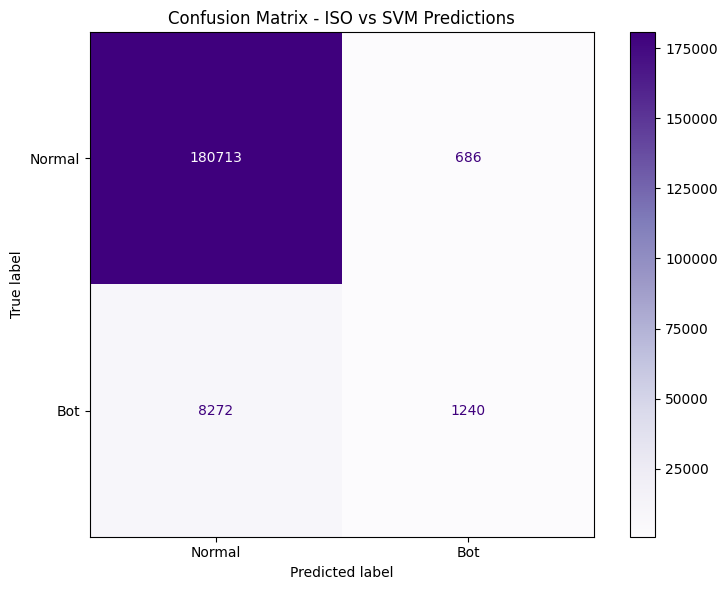

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'data' DataFrame contains 'ISO_Predicted_Label' and 'SVM_Predicted_Label'
# Replace this with the actual loading of your 'data' DataFrame
# data = pd.read_csv('your_data_file.csv')

# Compute confusion matrices
confusion_matrix_iso_vs_svm = confusion_matrix(data['ISO_Predicted_Label'], data['SVM_Predicted_Label'])

# Plotting confusion matrices side by side
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# ISO vs SVM Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix_iso_vs_svm, display_labels=['Normal', 'Bot']).plot(cmap='Purples', ax=axes)
axes.set_title('Confusion Matrix - ISO vs SVM Predictions')

plt.tight_layout()
plt.show()
